In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 1. 데이터 준비
def prepare_transfer_data(file_path):

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    data = pd.read_csv(file_path)
    required_columns = ['Overall', 'Potential', 'Age', 'Best Position', 'Club']
    
    # 필요한 열이 있는지 확인
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing required columns in dataset: {required_columns}")
    
    return data

# 2. 특성 엔지니어링
# FIFA 데이터를 기반으로 주요 특성과 상위 클럽 여부 레이블을 생성합니다.
def create_features(data, top_clubs):
    features = data[['Overall', 'Potential', 'Age', 'Best Position', 'Club']].copy()
    features['Top_Club'] = data['Club'].apply(lambda x: 1 if x in top_clubs else 0)
    return features

# 3. 모델 학습
def train_transfer_model(X, y, model_path="transfer_model.pkl", scaler_path="scaler.pkl"):

    # 데이터 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    
    # 성능 평가
    y_pred = model.predict(X_test)
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))
    
    # 모델 및 스케일러 저장
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"Model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")
    
    return model, scaler

# 4. 선수 추천
def recommend_players(data, model, scaler, position='CDM', top_n=10, weights=None):
    if weights is None:
        weights = {'transfer_prob': 0.4, 'overall': 0.3, 'potential': 0.2, 'age': 0.1}
    
    candidates = data[
        (data['Best Position'] == position) & 
        (data['Club'] != 'Liverpool') & 
        (data['Overall'] >= 80)
    ].copy()
    
    # 특성 추출
    X = candidates[['Overall', 'Potential', 'Age']].copy()
    X_scaled = scaler.transform(X)
    transfer_probs = model.predict_proba(X_scaled)[:, 1]
    
    # 추천 점수 계산
    candidates['Recommendation_Score'] = (
        transfer_probs * weights['transfer_prob'] +
        (candidates['Overall'] / 100) * weights['overall'] +
        (candidates['Potential'] / 100) * weights['potential'] +
        (1 - candidates['Age'] / 40) * weights['age']
    )
    
    recommendations = candidates.nlargest(top_n, 'Recommendation_Score')[
        ['Name', 'Club', 'Age', 'Overall', 'Potential', 'Recommendation_Score']
    ]
    
    return recommendations

# 5. 시각화
def plot_recommendations(recommendations):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # 추천 점수
    sns.barplot(
        data=recommendations,
        x='Recommendation_Score',
        y='Name',
        ax=axes[0, 0],
        palette='viridis',
        legend=False  # 범례 제거
    )
    axes[0, 0].set_title('Recommendation Scores')
    
    # 현재 능력치
    sns.barplot(
        data=recommendations,
        x='Overall',
        y='Name',
        ax=axes[0, 1],
        palette='viridis',
        legend=False  # 범례 제거
    )
    axes[0, 1].set_title('Overall Ratings')
    
    # 잠재력
    sns.barplot(
        data=recommendations,
        x='Potential',
        y='Name',
        ax=axes[1, 0],
        palette='viridis',
        legend=False  # 범례 제거
    )
    axes[1, 0].set_title('Potential Ratings')
    
    # 나이 분포
    sns.barplot(
        data=recommendations,
        x='Age',
        y='Name',
        ax=axes[1, 1],
        palette='viridis',
        legend=False  # 범례 제거
    )
    axes[1, 1].set_title('Age Distribution')
    
    plt.tight_layout()
    return fig


In [19]:
# 상위 클럽 목록
top_clubs = ['Liverpool', 'Manchester City', 'Real Madrid', 'Barcelona', 'Bayern München', 'Paris Saint-Germain']

# 데이터 준비
try:
    file_path = "./data/FIFA22_official_data.csv"
    data = prepare_transfer_data(file_path)
except Exception as e:
    print(f"Error: {e}")
    exit(1)

# 특성 추출
features = create_features(data, top_clubs)
X = features[['Overall', 'Potential', 'Age']]
y = features['Top_Club']

# 모델 학습
model, scaler = train_transfer_model(X, y)

# CDM 포지션 선수 추천
recommendations = recommend_players(data, model, scaler, position='GK', top_n=10)
print("\nRecommended GK Players for Liverpool:")
print(recommendations)


Model Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3316
           1       0.25      0.08      0.12        26

    accuracy                           0.99      3342
   macro avg       0.62      0.54      0.56      3342
weighted avg       0.99      0.99      0.99      3342

Model saved to transfer_model.pkl
Scaler saved to scaler.pkl

Recommended GK Players for Liverpool:
                Name                 Club  Age  Overall  Potential  \
14608  G. Donnarumma  Paris Saint-Germain   22       89         93   
11192        Ederson      Manchester City   27       89         91   
15026    K. Casteels        VfL Wolfsburg   29       86         87   
14087       K. Navas  Paris Saint-Germain   34       88         88   
15056     P. Gulácsi           RB Leipzig   31       85         85   
14244       J. Oblak   Atlético de Madrid   28       91         93   
14937    T. Courtois       Real Madrid CF   29       89        

C:\Users\ehdgu\AppData\Local\Temp\ipykernel_12000\2544643499.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ehdgu\AppData\Local\Temp\ipykernel_12000\2544643499.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ehdgu\AppData\Local\Temp\ipykernel_12000\2544643499.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ehdgu\AppData\Local\Temp\ipykernel_12000\2544643499.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable t

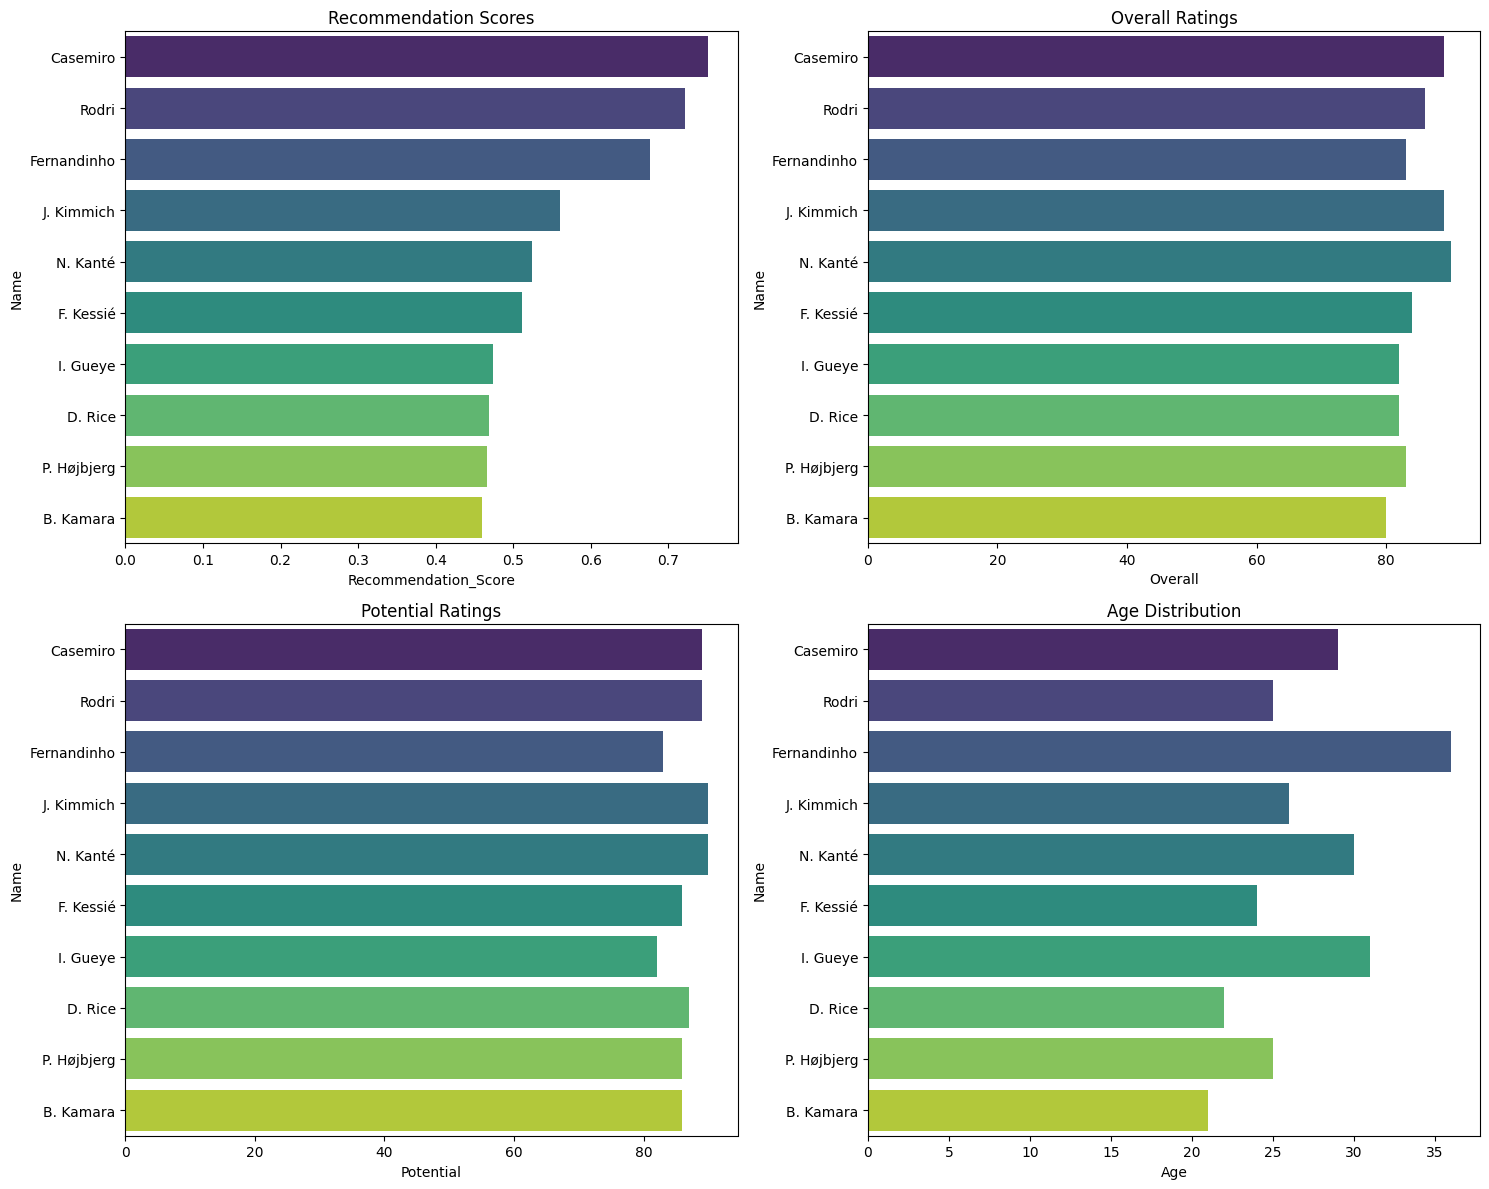

In [18]:
# 시각화
plot_recommendations(recommendations)
plt.show()